# Introduction
Welcome to UpLevel's 8th codealong! In this codealong, we'll be looking at Generative Adversarial Networks (GAN). 

GAN is pretty amazing, as you can use it to generate artificial images based on training data.

### What is GAN?
Conceived in 2014 by Ian Goodfellow, GAN is a technique used to create and refine new data. This allows people to create synthetic data for research or commercial uses.

It is composed of two networks:
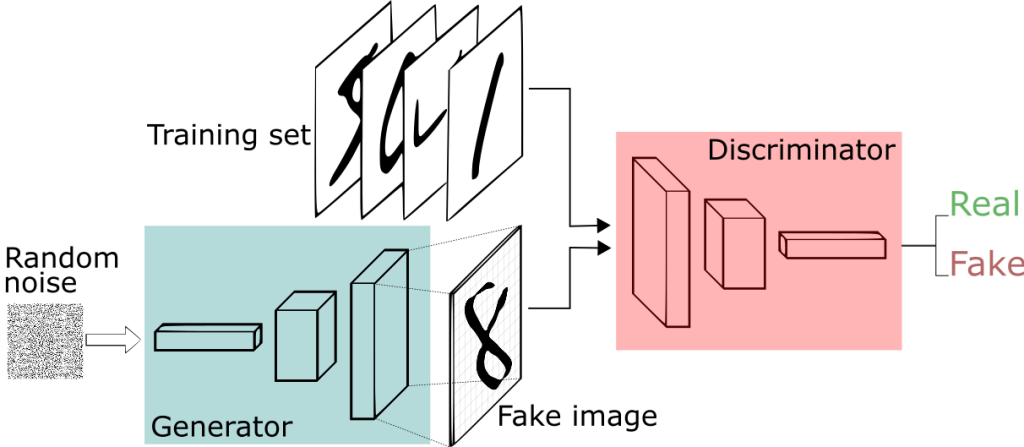

#### Generator
- tries to generate new data from signals, e.g., noise

#### Discriminator
- image classifier that rates the quality of the generator
- scale of 0 to 1
- if too low, generator corrects the data and resubmits to discriminator

# Expectation
GAN is still very hard to execute because:
- if the discriminator is too lax, it will accept anything from the generator
- if the discriminator is too strict, it will reject everything from the discriminator

### Truth
![Truth](https://miro.medium.com/max/1400/1*r8cuSIaM5oHUERP01TCTxg.jpeg)

# Let's run code!

### Change runtime
Make sure it's in GPU now!

### Import libraries

In [ ]:
# import libraries
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import random
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Reshape, Dense, Dropout, \
    Activation, LeakyReLU, Conv2D, Conv2DTranspose, \
    MaxPooling2D, UpSampling2D, Flatten, BatchNormalization
from keras.initializers import glorot_uniform, glorot_normal
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

### Set up the Images
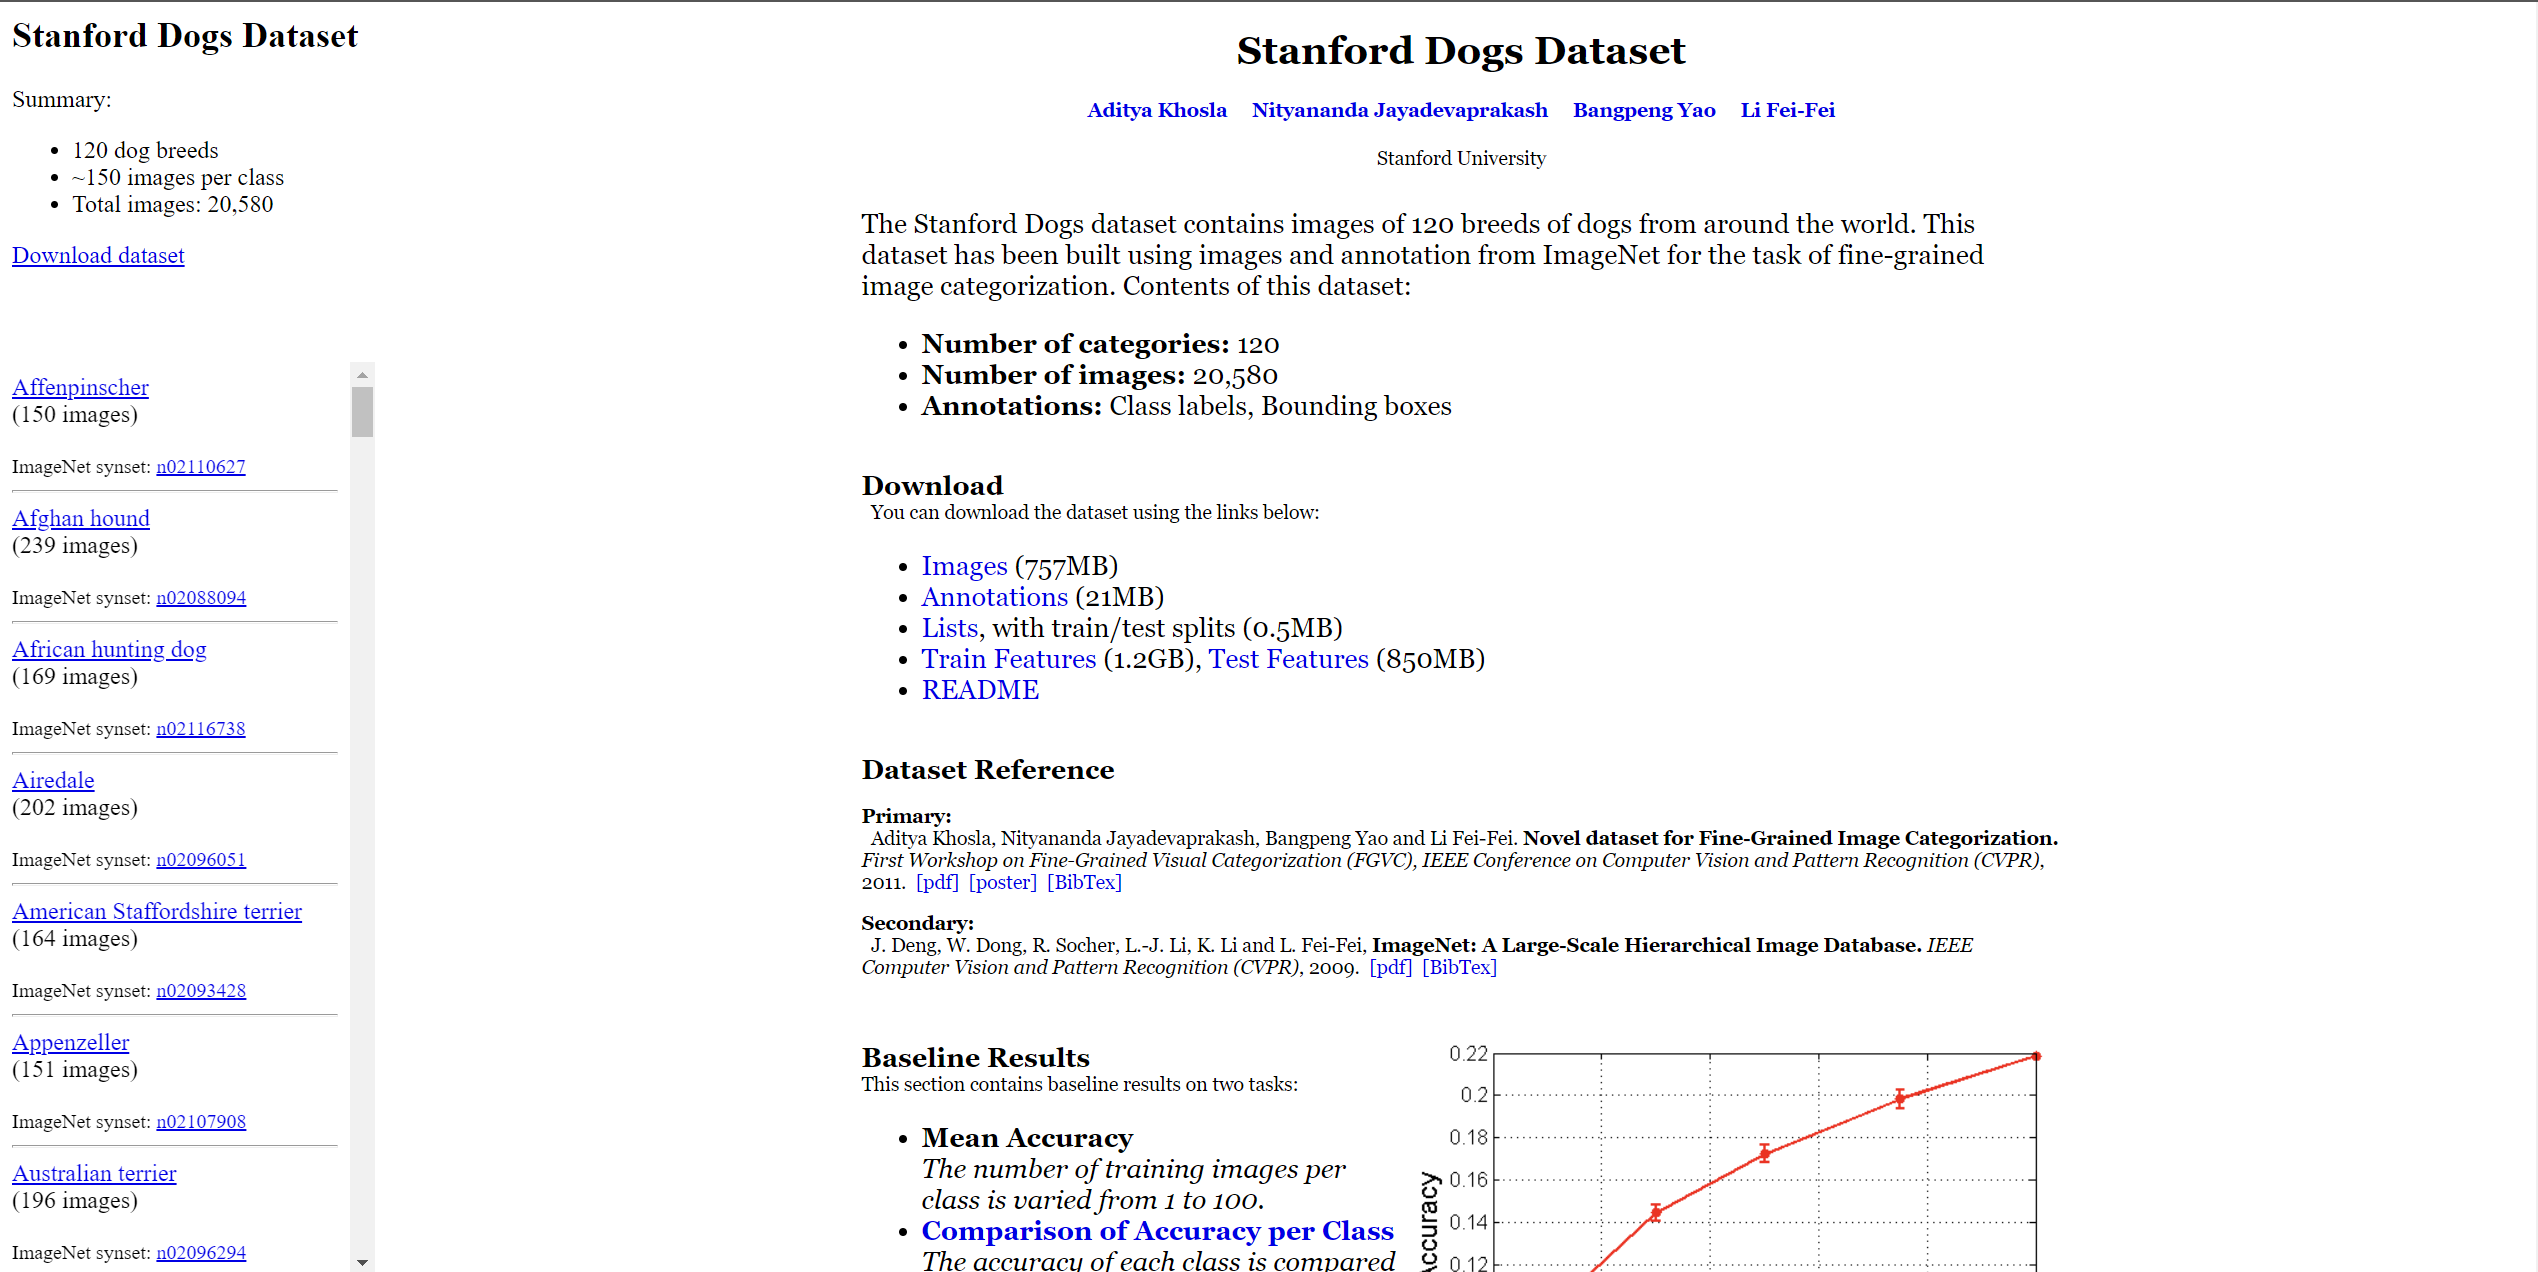
We'll be using images from ImageNetDogs. Link [here](http://vision.stanford.edu/aditya86/ImageNetDogs/).

In [ ]:
# Create a folder called Images
if "Images" not in os.listdir():
    os.system("cd ~/Project/")
    os.system("wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar")
    os.system("tar -xvf images.tar")

os.listdir("Images")

DATA_DIR = os.getcwd() + "/Images/"

# Define the resizing of the images to 100 x 100
RESIZE_TO = 100, 100
x, y = [], []
for i in range(len(os.listdir(DATA_DIR))):
    for path in [f for f in os.listdir(DATA_DIR+os.listdir(DATA_DIR)[i])]:
        # resize the images using cv2
        x.append(cv2.resize(cv2.imread(DATA_DIR + os.listdir(DATA_DIR)[i] + '/' + path), (RESIZE_TO)))
        
        # get the label of the image
        label = os.listdir(DATA_DIR)[i]
        y.append(label)

x, y = np.array(x), np.array(y)
y_label = y

# Encode the label into a proper integer
le = preprocessing.LabelEncoder()
le.fit(os.listdir(DATA_DIR))
y = le.transform(y)
print(x.shape, y.shape)

### Split the data into train and test
...and save them into NumPy array file for storage.

In [ ]:
# Split the data
x_train, x_test, y_train, y_test, y_label_train, y_label_test = train_test_split(x, y, y_label, random_state=1, test_size=0.3)

# Save the split data
np.save("x_train.npy", x_train)
np.save("y_train.npy", y_train)
np.save("y_label_train.npy", y_label_train)
np.save("x_test.npy", x_test)
np.save("y_test.npy", y_test)
np.save("y_label_test.npy", y_label_test)

### [Optional] Set up the random seed 

In [ ]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
weight_init = glorot_normal(seed=SEED)

### Build the generator

In [ ]:
# Load the real images
real_100 = np.load('x_train.npy')

real = np.ndarray(shape=(real_100.shape[0], 64, 64, 3))
for i in range(real_100.shape[0]):
    real[i] = cv2.resize(real_100[i], (64, 64))

img_size = real[0].shape

# Define latent space of noise
z = (100,)

# Definte optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

# Build Generator
def generator_conv():
    noise = Input(shape=z)
    x = Dense(4*4*128)(noise)
    x = LeakyReLU(alpha=0.2)(x)
    ## Output size: 4 x 4 x 128
    x = Reshape((4, 4, 128))(x)
    

    x = Conv2DTranspose(filters=128,
                        kernel_size=(4, 4),
                        strides=(2, 2),
                        padding='same')(x)
    ## Size: 8 x 8 x 128
    x = LeakyReLU(0.2)(x)
    # x = BatchNormalization()(x)

    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(x)
    ## Size: 16 x 16 x 128

    x = LeakyReLU(0.2)(x)
    # x = BatchNormalization()(x)

    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(x)
    ## Size: 32 x 32 x 128

    x = LeakyReLU(0.2)(x)
    # x = BatchNormalization()(x)

    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(x)
    ## Size: 64 x 64 x 128

    x = LeakyReLU(0.2)(x)
    # x = BatchNormalization()(x)

    generated = Conv2D(3, (8, 8), padding='same', activation='tanh')(x)
    ## Size: 64 x 64 x 3

    generator = Model(inputs=noise, outputs=generated)
    return generator

### Build the discriminator

In [ ]:
# Build Discriminator
def discriminator_conv():
    img = Input(img_size)
    x = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(img)
    x = LeakyReLU(0.2)(x)
    # x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    # x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    # x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    # x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    # x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    out = Dense(1, activation='sigmoid')(x)

    discriminator = Model(inputs=img, outputs=out)
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return discriminator

### Compile model
Note that it's neater to define your own model Object, e.g., GAN.

In [ ]:
# GAN model compiling
def generator_trainer(generator, discriminator):

    discriminator.trainable = False

    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')

    return model

class GAN():
    def __init__(self, model='conv', img_shape=(64, 64, 3), latent_space=(100,)):
        self.img_size = img_shape  # channel_last
        self.z = latent_space
        self.optimizer = Adam(0.0002, 0.5)

        self.gen = generator_conv()
        self.discr = discriminator_conv()

        self.train_gen = generator_trainer(self.gen, self.discr)
        self.loss_D, self.loss_G = [], []

    def train(self, imgs, epochs=50, batch_size=128):
        # load data
        imgs = (imgs - 127.5)/127.5
        bs_half = batch_size//2

        for epoch in range(epochs):
            # Get a half batch of random real images
            idx = np.random.randint(0, imgs.shape[0], bs_half)
            real_img = imgs[idx]

            # Generate a half batch of new images
            noise = np.random.normal(0, 1, size=((bs_half,) + self.z))
            fake_img = self.gen.predict(noise)

            ## One-sided label smoothing
            real_label = np.random.uniform(0.9, 1.0, (bs_half, 1))
            fake_label = np.zeros((bs_half, 1))

            ## Random flip 5% labels/data
            mixpoint = int(bs_half * 0.95)
            real_label_mix = np.concatenate([real_label[:mixpoint], fake_label[mixpoint:]])
            fake_label_mix = np.concatenate([fake_label[:mixpoint], real_label[mixpoint:]])
            np.random.shuffle(real_label_mix)
            np.random.shuffle(fake_label_mix)

            # Train the discriminator
            loss_fake = self.discr.train_on_batch(fake_img, fake_label_mix)
            loss_real = self.discr.train_on_batch(real_img, real_label_mix)
            self.loss_D.append(0.5 * np.add(loss_fake, loss_real))

            # Train the generator
            noise = np.random.normal(0, 1, size=((batch_size,) + self.z))
            loss_gen = self.train_gen.train_on_batch(noise, np.ones(batch_size))
            self.loss_G.append(loss_gen)

            # Print statement to track the training progress
            if (epoch + 1) * 10 % epochs == 0:
                print('Epoch (%d / %d): [Loss_D_real: %f, Loss_D_fake: %f, acc_of_fake: %.2f%%] [Loss_G: %f]' %
                  (epoch+1, epochs, loss_real[0], loss_fake[0], 200*self.loss_D[-1][1], loss_gen))

        return


### Define function to display image

In [ ]:
def plt_img(gan, r=2, c=4):
    # generate 100 random noises
    noise = np.random.normal(0, 1, (r * c, 100))
    
    # Use your model to predict images based on noise
    gen_imgs = gan.gen.predict(noise)
    
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    # Create a plot
    fig, axs = plt.subplots(r, c)
    cnt = 0
    
    # Loop and plot
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    return

### Party time

In [ ]:
# Instantiate the GAN object
gan = GAN()

LEARNING_STEPS = 800
BATCH_SIZE = 128
EPOCHS = 100

for learning_step in range(LEARNING_STEPS):
    print('LEARNING STEP # ', learning_step+1, '-'*50)

    gan.train(real, epochs=EPOCHS, batch_size=BATCH_SIZE)
    
    # Show images at different training epochs
    if (learning_step+1)%5 == 0:
        plt_img(gan)

    # Save the model to continue run or for usage    
    if (learning_step+1)%50 == 0:
        gan.gen.save('gan_generator_%d_v2.h5' % (learning_step*100+100))